Trial 36 Complete [00h 00m 03s]
loss: 2.6948769092559814

Best loss So Far: 0.8497473001480103
Total elapsed time: 00h 01m 55s
INFO:tensorflow:Oracle triggered exit
None
The optimal number of units in the first densely-connected 0.0009000000000000001
The optimal learning rate for the optimizer is  128
The best loss is  mean_squared_logarithmic_error
Best epoch: 1426
Epoch 1/1426
16/16 [==============================] - 2s 46ms/step - loss: 1.6484 - val_loss: 0.7227
Epoch 2/1426
16/16 [==============================] - 0s 13ms/step - loss: 0.9117 - val_loss: 0.7430
Epoch 3/1426
16/16 [==============================] - 0s 15ms/step - loss: 0.8733 - val_loss: 0.7016
Epoch 4/1426
16/16 [==============================] - 0s 17ms/step - loss: 0.8443 - val_loss: 0.6713
Epoch 5/1426
16/16 [==============================] - 0s 17ms/step - loss: 0.8245 - val_loss: 0.6599
Epoch 6/1426
16/16 [==============================] - 0s 17ms/step - loss: 0.8079 - val_loss: 0.6521
Epoch 7/1426
16/16 [=====

16/16 [==============================] - 0s 19ms/step - loss: 0.3100 - val_loss: 0.2448
Epoch 78/1426
16/16 [==============================] - 0s 22ms/step - loss: 0.3150 - val_loss: 0.2603
Epoch 79/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.3061 - val_loss: 0.2440
Epoch 80/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.3031 - val_loss: 0.2533
Epoch 81/1426
16/16 [==============================] - 0s 20ms/step - loss: 0.3047 - val_loss: 0.2489
Epoch 82/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.2975 - val_loss: 0.2667
Epoch 83/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.3056 - val_loss: 0.2574
Epoch 84/1426
16/16 [==============================] - 0s 20ms/step - loss: 0.2962 - val_loss: 0.2454
Epoch 85/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.2879 - val_loss: 0.2599
Epoch 86/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.2836 - val_loss: 0

Epoch 157/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.1650 - val_loss: 0.3026
Epoch 158/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.1626 - val_loss: 0.2928
Epoch 159/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.1611 - val_loss: 0.2849
Epoch 160/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.1705 - val_loss: 0.3093
Epoch 161/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.1687 - val_loss: 0.3167
Epoch 162/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.1778 - val_loss: 0.2949
Epoch 163/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.1592 - val_loss: 0.3084
Epoch 164/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.1576 - val_loss: 0.3080
Epoch 165/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.1892 - val_loss: 0.3240
Epoch 166/1426
16/16 [==============================] - 0s 18ms/step - lo

16/16 [==============================] - 0s 19ms/step - loss: 0.0807 - val_loss: 0.3603
Epoch 237/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0793 - val_loss: 0.3770
Epoch 238/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0810 - val_loss: 0.3662
Epoch 239/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0748 - val_loss: 0.3635
Epoch 240/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0727 - val_loss: 0.3678
Epoch 241/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0755 - val_loss: 0.3749
Epoch 242/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0736 - val_loss: 0.3807
Epoch 243/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0830 - val_loss: 0.3473
Epoch 244/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0840 - val_loss: 0.3805
Epoch 245/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0795 - va

16/16 [==============================] - 0s 19ms/step - loss: 0.0504 - val_loss: 0.4099
Epoch 316/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0493 - val_loss: 0.3797
Epoch 317/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0479 - val_loss: 0.4021
Epoch 318/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0476 - val_loss: 0.4198
Epoch 319/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0449 - val_loss: 0.3787
Epoch 320/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0450 - val_loss: 0.4181
Epoch 321/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0458 - val_loss: 0.4096
Epoch 322/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0460 - val_loss: 0.4124
Epoch 323/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0471 - val_loss: 0.4040
Epoch 324/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0472 - va

16/16 [==============================] - 0s 18ms/step - loss: 0.0345 - val_loss: 0.4021
Epoch 395/1426
16/16 [==============================] - 0s 20ms/step - loss: 0.0362 - val_loss: 0.4191
Epoch 396/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0393 - val_loss: 0.4157
Epoch 397/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0391 - val_loss: 0.4208
Epoch 398/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0347 - val_loss: 0.4374
Epoch 399/1426
16/16 [==============================] - 0s 20ms/step - loss: 0.0323 - val_loss: 0.4248
Epoch 400/1426
16/16 [==============================] - 0s 20ms/step - loss: 0.0323 - val_loss: 0.4301
Epoch 401/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0342 - val_loss: 0.4247
Epoch 402/1426
16/16 [==============================] - 0s 20ms/step - loss: 0.0361 - val_loss: 0.4213
Epoch 403/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0413 - va

16/16 [==============================] - 0s 18ms/step - loss: 0.0261 - val_loss: 0.3883
Epoch 474/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0229 - val_loss: 0.4075
Epoch 475/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0212 - val_loss: 0.4047
Epoch 476/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0208 - val_loss: 0.3984
Epoch 477/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0190 - val_loss: 0.4188
Epoch 478/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0183 - val_loss: 0.4035
Epoch 479/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0186 - val_loss: 0.4028
Epoch 480/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0174 - val_loss: 0.4079
Epoch 481/1426
16/16 [==============================] - 0s 20ms/step - loss: 0.0190 - val_loss: 0.4266
Epoch 482/1426
16/16 [==============================] - 0s 20ms/step - loss: 0.0173 - va

16/16 [==============================] - 0s 18ms/step - loss: 0.0221 - val_loss: 0.4280
Epoch 553/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0181 - val_loss: 0.4123
Epoch 554/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0175 - val_loss: 0.4089
Epoch 555/1426
16/16 [==============================] - 0s 20ms/step - loss: 0.0199 - val_loss: 0.3918
Epoch 556/1426
16/16 [==============================] - 0s 22ms/step - loss: 0.0276 - val_loss: 0.4282
Epoch 557/1426
16/16 [==============================] - 0s 20ms/step - loss: 0.0189 - val_loss: 0.4141
Epoch 558/1426
16/16 [==============================] - 0s 22ms/step - loss: 0.0234 - val_loss: 0.4005
Epoch 559/1426
16/16 [==============================] - 0s 22ms/step - loss: 0.0186 - val_loss: 0.4222
Epoch 560/1426
16/16 [==============================] - 0s 21ms/step - loss: 0.0240 - val_loss: 0.4291
Epoch 561/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0167 - va

16/16 [==============================] - 0s 18ms/step - loss: 0.0143 - val_loss: 0.4093
Epoch 632/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0127 - val_loss: 0.4094
Epoch 633/1426
16/16 [==============================] - 0s 17ms/step - loss: 0.0123 - val_loss: 0.4153
Epoch 634/1426
16/16 [==============================] - 0s 17ms/step - loss: 0.0122 - val_loss: 0.3923
Epoch 635/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0144 - val_loss: 0.4220
Epoch 636/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0140 - val_loss: 0.4255
Epoch 637/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0141 - val_loss: 0.3993
Epoch 638/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0130 - val_loss: 0.4320
Epoch 639/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0131 - val_loss: 0.4007
Epoch 640/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0127 - va

16/16 [==============================] - 0s 18ms/step - loss: 0.0073 - val_loss: 0.3999
Epoch 711/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0073 - val_loss: 0.4006
Epoch 712/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0074 - val_loss: 0.3956
Epoch 713/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0074 - val_loss: 0.3979
Epoch 714/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0070 - val_loss: 0.4034
Epoch 715/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0065 - val_loss: 0.3998
Epoch 716/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0068 - val_loss: 0.3974
Epoch 717/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0091 - val_loss: 0.3999
Epoch 718/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0126 - val_loss: 0.4017
Epoch 719/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0162 - va

16/16 [==============================] - 0s 18ms/step - loss: 0.0087 - val_loss: 0.3937
Epoch 790/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0077 - val_loss: 0.4174
Epoch 791/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0076 - val_loss: 0.4010
Epoch 792/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0082 - val_loss: 0.4064
Epoch 793/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0080 - val_loss: 0.3876
Epoch 794/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0080 - val_loss: 0.4214
Epoch 795/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0139 - val_loss: 0.3885
Epoch 796/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0146 - val_loss: 0.3994
Epoch 797/1426
16/16 [==============================] - 0s 21ms/step - loss: 0.0180 - val_loss: 0.4190
Epoch 798/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0206 - va

16/16 [==============================] - 0s 18ms/step - loss: 0.0059 - val_loss: 0.4038
Epoch 869/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0060 - val_loss: 0.3942
Epoch 870/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0051 - val_loss: 0.3814
Epoch 871/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0045 - val_loss: 0.4055
Epoch 872/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0036 - val_loss: 0.3873
Epoch 873/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0033 - val_loss: 0.3945
Epoch 874/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0032 - val_loss: 0.3898
Epoch 875/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0032 - val_loss: 0.3976
Epoch 876/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0032 - val_loss: 0.3930
Epoch 877/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0031 - va

16/16 [==============================] - 0s 18ms/step - loss: 0.0102 - val_loss: 0.3730
Epoch 948/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0159 - val_loss: 0.4008
Epoch 949/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0145 - val_loss: 0.3964
Epoch 950/1426
16/16 [==============================] - 0s 20ms/step - loss: 0.0157 - val_loss: 0.4142
Epoch 951/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0224 - val_loss: 0.3967
Epoch 952/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0273 - val_loss: 0.4262
Epoch 953/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0240 - val_loss: 0.4253
Epoch 954/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0390 - val_loss: 0.4302
Epoch 955/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0288 - val_loss: 0.3652
Epoch 956/1426
16/16 [==============================] - ETA: 0s - loss: 0.042 - 0s 19ms/

Epoch 1026/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0043 - val_loss: 0.3778
Epoch 1027/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0039 - val_loss: 0.3852
Epoch 1028/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0036 - val_loss: 0.3746
Epoch 1029/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0035 - val_loss: 0.3753
Epoch 1030/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0043 - val_loss: 0.3933
Epoch 1031/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0038 - val_loss: 0.3809
Epoch 1032/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0040 - val_loss: 0.3736
Epoch 1033/1426
16/16 [==============================] - 0s 17ms/step - loss: 0.0038 - val_loss: 0.3912
Epoch 1034/1426
16/16 [==============================] - 0s 17ms/step - loss: 0.0036 - val_loss: 0.3876
Epoch 1035/1426
16/16 [==============================] - 0s 18ms

16/16 [==============================] - 0s 19ms/step - loss: 0.0014 - val_loss: 0.3933
Epoch 1105/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0014 - val_loss: 0.3886
Epoch 1106/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.3911
Epoch 1107/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0014 - val_loss: 0.3865
Epoch 1108/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.3935
Epoch 1109/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.3880
Epoch 1110/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.3929
Epoch 1111/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.3840
Epoch 1112/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.3934
Epoch 1113/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.

16/16 [==============================] - 0s 18ms/step - loss: 0.0010 - val_loss: 0.3826
Epoch 1183/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0011 - val_loss: 0.3909
Epoch 1184/1426
16/16 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.3850
Epoch 1185/1426
16/16 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.3850
Epoch 1186/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0012 - val_loss: 0.3904
Epoch 1187/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0011 - val_loss: 0.3882
Epoch 1188/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0012 - val_loss: 0.3861
Epoch 1189/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.3915
Epoch 1190/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.3858
Epoch 1191/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.

16/16 [==============================] - 0s 19ms/step - loss: 9.4839e-04 - val_loss: 0.3823
Epoch 1261/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0011 - val_loss: 0.3828
Epoch 1262/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0011 - val_loss: 0.3904
Epoch 1263/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.3893
Epoch 1264/1426
16/16 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.3813
Epoch 1265/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0014 - val_loss: 0.3837
Epoch 1266/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0015 - val_loss: 0.3937
Epoch 1267/1426
16/16 [==============================] - 0s 17ms/step - loss: 0.0015 - val_loss: 0.3875
Epoch 1268/1426
16/16 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.3809
Epoch 1269/1426
16/16 [==============================] - 0s 17ms/step - loss

Epoch 1339/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0011 - val_loss: 0.3734
Epoch 1340/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0011 - val_loss: 0.3645
Epoch 1341/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0010 - val_loss: 0.3744
Epoch 1342/1426
16/16 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.3667
Epoch 1343/1426
16/16 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.3689
Epoch 1344/1426
16/16 [==============================] - 0s 19ms/step - loss: 0.0012 - val_loss: 0.3724
Epoch 1345/1426
16/16 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.3728
Epoch 1346/1426
16/16 [==============================] - 0s 17ms/step - loss: 0.0013 - val_loss: 0.3659
Epoch 1347/1426
16/16 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.3701
Epoch 1348/1426
16/16 [==============================] - 0s 18ms

16/16 [==============================] - 0s 20ms/step - loss: 7.8677e-04 - val_loss: 0.3826
Epoch 1418/1426
16/16 [==============================] - 0s 18ms/step - loss: 7.5703e-04 - val_loss: 0.3824
Epoch 1419/1426
16/16 [==============================] - 0s 18ms/step - loss: 7.3002e-04 - val_loss: 0.3823
Epoch 1420/1426
16/16 [==============================] - 0s 18ms/step - loss: 7.0457e-04 - val_loss: 0.3820
Epoch 1421/1426
16/16 [==============================] - 0s 18ms/step - loss: 6.8087e-04 - val_loss: 0.3820
Epoch 1422/1426
16/16 [==============================] - 0s 19ms/step - loss: 6.5881e-04 - val_loss: 0.3821
Epoch 1423/1426
16/16 [==============================] - 0s 18ms/step - loss: 6.3805e-04 - val_loss: 0.3819
Epoch 1424/1426
16/16 [==============================] - 0s 18ms/step - loss: 6.1872e-04 - val_loss: 0.3819
Epoch 1425/1426
16/16 [==============================] - 0s 17ms/step - loss: 6.0032e-04 - val_loss: 0.3819
Epoch 1426/1426
16/16 [=====================

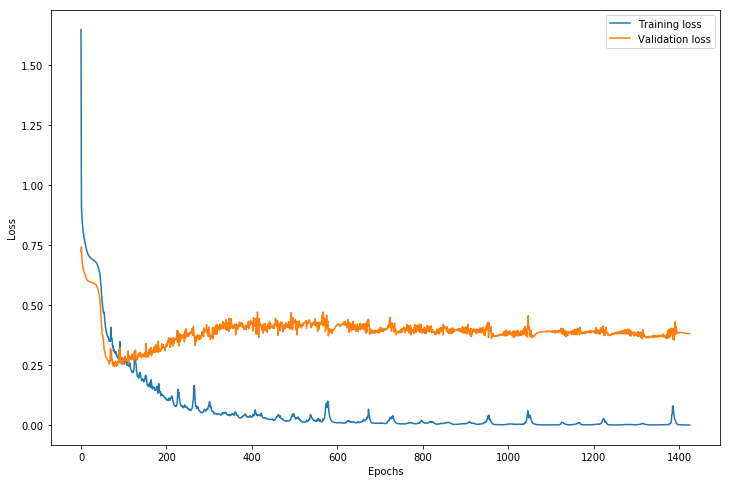

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (89, 128)                 66560     
                                                                 
 dense_2 (Dense)             (89, 1)                   129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
None


NameError: name 'test_anom' is not defined

In [5]:
from math import sqrt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from keras import backend as K
from numpy import concatenate
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import requests
import pandas as pd
import sqlite3
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.layers import Dropout
import keras_tuner as kt


# conn =sqlite3.connect('sqlite_8.db')
# c = conn.cursor()

# c.execute("SELECT name FROM sqlite_master WHERE type='table';")
# print(c.fetchall())

# c.execute("SELECT * FROM syslogs ORDER BY timestamp DESC LIMIT 1")
# print(c.fetchall())


limit = '16'
bucket_size = 10
timing =90


variable = int(60*bucket_size)

df = pd.read_pickle("dataframe.gz")


def makeDataframe(df):
    import datetime

    atype = str(df.tail(1)['bucket'].values[0])
    ctype = str(df.head(1)['bucket'].values[0])

    sample_series = []

    end = datetime.datetime.strptime(atype, '%Y-%m-%d %H:%M:%S')
    # start = end - datetime.timedelta(minutes = 3000)
    start = datetime.datetime.strptime(ctype, '%Y-%m-%d %H:%M:%S')

    delta = datetime.timedelta(minutes=bucket_size)
    # start = datetime.datetime.strptime( start, '%Y-%m-%d %H:%M:%S' )
    # end = datetime.datetime.strptime( end, '%Y-%m-%d %H:%M:%S' )
    t = start
    while t <= end :
        sample_series.append(datetime.datetime.strftime( t, '%Y-%m-%d %H:%M:%S'))
        t += delta
    sample = pd.DataFrame(sample_series)
    sample =sample.rename(columns={0:"bucket"})

    sample.insert(1, 'msg_freq',0)

    merged_df = df.merge(sample, how = 'outer', on = ['bucket'])
    new_df = merged_df.sort_values('bucket')
    new_df = new_df.drop(columns = ['msg_freq_y']).fillna(0)

    new_df  = new_df.reset_index()
    new_df = new_df.iloc[:,1:]
    df = new_df.rename(columns={"msg_freq_x": "msg_freq"})
    
    return df



def cumulativeFreq(df):
    df_cs = df.copy()
    df_cs['bucket'] = pd.to_datetime(df_cs['bucket'])
    df_cs["msg_freq"] = df_cs["msg_freq"].iloc[:].groupby([df_cs['bucket'].dt.hour, df_cs['bucket'].dt.date]).cumsum()
    
    return df_cs



def Normalizer(df):
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import MinMaxScaler

    df1 = df.iloc[:,1:]   #change required
#     values = dff.values
#     values = values.astype('float32')
#     # normalize features
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     scaled = scaler.fit_transform(values)
#     dff = pd.DataFrame(scaled, columns=df.columns[1:]) #change required
    dff = df1/df1.max()
    dff.insert(0, 'bucket', df["bucket"]) #change required
    
    return dff


def sigmoidDataframe(df):
    
    def sigmoid(x):
        a=0.7
        return 1/(1+5*np.exp(-a*x))
    
    dff = df.copy()
    dff['msg_freq'] = sigmoid(dff['msg_freq'])
    return dff

df = makeDataframe(df)
df_cs = cumulativeFreq(df)

dfn = Normalizer(df)
dfn_cs = Normalizer(df_cs)


Values = df_cs.iloc[:,1].values

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)



# choose a number of time steps; basically the memory of the network
n_steps = int(timing/bucket_size)

# split into samples
X, y = split_sequence(Values, n_steps)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))


def wisesplit(num,div):
    
    part = num - div
    while part/num > 0.8:
        part = part-div
    
    return part

def print_factors(num):
    import numpy as np
    factors = []
    for i in range(1, num + 1):
        if num % i == 0:
            factors.append(i)
    return np.array(factors)

arr =print_factors(len(X))
div = arr[int(0.6*arr.shape[0])]

split = wisesplit(len(X),div)
# split =int(0.8*len(X))
# split = -272

train_X = np.array(X)[:split]
train_y = np.array(y)[:split]
test_X = np.array(X)[split:]
test_y = np.array(y)[split:]

train_y =train_y.reshape((train_y.shape[0],1))

test_y = test_y.reshape((test_y.shape[0],1))

def compute_hcf(x, y):

# choose the smaller number
    if x > y:
        smaller = y
    else:
        smaller = x
    for i in range(1, smaller+1):
        if((x % i == 0) and (y % i == 0)):
            hcf = i 
    return hcf

batchsize = compute_hcf(train_X.shape[0],test_X.shape[0])
batch_arr = print_factors(batchsize)
bt = batch_arr[-1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

    
    
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=128, step =32),return_sequences=False, batch_input_shape=(bt,train_X.shape[1],train_X.shape[2]), stateful=True))
#     for i in range(hp.Int('n_layers', 1, 4)):
#         model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=96,step=32),return_sequences=True))
#     model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=128,step=32)))
#     model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    hp_loss = hp.Choice('loss', values=['mean_squared_logarithmic_error'])
    model.add(Dense(train_y.shape[1]))
    model.compile(loss=hp_loss, optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=0.0001,max_value=0.001, step =0.0001)))
    return model

tuner = kt.Hyperband(build_model,
                     objective='loss',
                     max_epochs=1500,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


print(tuner.search(
        x=train_X,
        y=train_y,
        epochs=1500,
        batch_size = bt,
        validation_data=(test_X,test_y)
))

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = tuner.get_best_models()[0]

print("The optimal number of units in the first densely-connected", best_hps.get('input_unit'))
print("The optimal learning rate for the optimizer is ",best_hps.get('learning_rate') )
print("The best loss is ", best_hps.get('loss'))



# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x=train_X, y=train_y, epochs=1500, validation_data=(test_X,test_y), batch_size=batchsize, verbose =0, shuffle=False)

loss_per_epoch = history.history['loss']
best_epoch = loss_per_epoch.index(min(loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
final_history = hypermodel.fit(x=train_X, y=train_y, epochs=best_epoch, validation_data=(test_X,test_y), batch_size=batchsize, verbose =1, shuffle=False)
hyper_pred= hypermodel.predict(test_X,bt)

#PLOTTING

plt.figure(figsize=(12,8))   
plt.plot(final_history.history['loss'],label='Training loss')
plt.plot(final_history.history['val_loss'], label ="Validation loss")
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
#             plt.ylim(0,0.2)
plt.legend(['Training loss', 'Validation loss'])
plt.savefig('bestmodel_loss_10_90_layer1.pdf', dpi=250)
plt.show()

print(hypermodel.summary())
hyper_pred_df = pd.DataFrame(hyper_pred.flatten())
test_anom = pd.DataFrame(test_y)

fig = go.Figure()    
fig.add_trace(go.Scatter(x=df_cs['bucket'][split+n_steps:], y= test_anom[0], name='actual'))
# fig.add_trace(go.Scatter(x=df_cs['bucket'][split+n_steps:], y= tuner_pred[0], name='tuner_prediction'))
# fig.add_trace(go.Scatter(x=df_cs['bucket'][split+n_steps:], y= pred_df[0], name= 'model_prediction'))
fig.add_trace(go.Scatter(x=df_cs['bucket'][split+n_steps:], y= hyper_pred_df[0], name='hypermodel_prediction'))
fig.update_layout(showlegend=True, title='Frequency v/s Time',width=1600, height=800)
fig.update_yaxes(title_text='Normalized frequency')
fig.update_xaxes(title_text='Time')
fig.update_layout(xaxis_range=['2022-01-09 12:00:00','2022-01-10 00:00:00'])
# fig.update_layout(yaxis_range=[-0.1,1])
fig.show()
fig.write_image("bestmodel_predictions_10_90_layer1.pdf")

89